<a href="https://colab.research.google.com/github/ANSHAY/deeplearning/blob/master/8_cats_vs_dogs/Copy_of_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of Cats vs Dogs using CNN with Tensorflow

## Download and unzip the dataset

In [0]:
import zipfile
import os
import random
from shutil import copyfile

In [29]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-06-14 09:35:33--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.122.255.148, 2a02:26f0:db:29f::e59, 2a02:26f0:db:2a3::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.122.255.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  57.1MB/s    in 17s     

2019-06-14 09:35:50 (46.9 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



## Define paths for data

In [0]:
try:
    os.mkdir('/tmp/cats_vs_dogs')
    os.mkdir('/tmp/cats_vs_dogs/models')
    os.mkdir('/tmp/cats_vs_dogs/train')
    os.mkdir('/tmp/cats_vs_dogs/test')
    os.mkdir('/tmp/cats_vs_dogs/train/cats')
    os.mkdir('/tmp/cats_vs_dogs/train/dogs')
    os.mkdir('/tmp/cats_vs_dogs/test/cats')
    os.mkdir('/tmp/cats_vs_dogs/test/dogs')
except OSError:
    pass

## Split the data into train and test

In [31]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats_vs_dogs/train/cats/"
TESTING_CATS_DIR = "/tmp/cats_vs_dogs/test/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats_vs_dogs/train/dogs/"
TESTING_DOGS_DIR = "/tmp/cats_vs_dogs/test/dogs/"

split_size = 0.99
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


## Main code starts

#### import all modules


In [0]:
# import all modules

import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3


#### define metadata


In [34]:
## define metadata
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
print("\nDefining metadata")
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
Nrows = 150
Ncols = 150
BATCH_SIZE = 20
NUM_EPOCHS = 74
FILTER_SIZE = (3,3)
model_path = "/model"+"_R"+str(Nrows)+"_C"+str(Ncols)+"_fs"+str(FILTER_SIZE[0])+"_ep"+str(NUM_EPOCHS)+".h5"
print("\nMetadata defined")

--2019-06-14 09:37:25--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   132MB/s    in 0.6s    

2019-06-14 09:37:26 (132 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]


Defining metadata

Metadata defined


#### Function to plot Loss and Accuracy of a model


In [0]:
# Function to plot Loss and Accuracy of a model

def plot_results(history):
    # Retrieve a list of list results on training and val data
    # sets for each training epoch
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    # Get number of epochs
    epochs=range(len(acc)) 
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, 'r', "Training Accuracy")
    plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.plot(epochs, val_loss, 'b', "Validation Loss")
    
    plt.title('Training and validation loss')


#### define callbacks


In [0]:
# define callbacks

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if (logs.get('acc') > 0.99):
            self.model.stop_training = True
            print ("\nStopping training as accuracy is above 99%")
callback = myCallback()

#### define model


In [0]:
# define model

def fetch_model(train_gen=None, val_gen=None):
    try:
        print("\nLoading saved model")
        model = tf.keras.models.load_model(model_path)
        print("\nmodel loaded")
    except:
        print("\nModel not found. Training new model...")
        pre_trained_model = InceptionV3(input_shape=(Nrows,Ncols,3),
                                        include_top=False,
                                        weights=None)
        pre_trained_model.load_weights(local_weights_file)
        num_layers = len(pre_trained_model.layers)
        for i, layer in enumerate(pre_trained_model.layers):
          if i < num_layers-14:
            layer.trainable=False
          else:
            layer.trainable=True            
        last_layer = pre_trained_model.get_layer('mixed7')
        last_output = last_layer.output
        last_layer.trainable = True
        x = tf.keras.layers.Conv2D(256, FILTER_SIZE, activation='relu')(last_output)
        x = tf.keras.layers.MaxPooling2D(2,2)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.models.Model(pre_trained_model.input, x)
        
        ## compile model
        model.compile(optimizer=RMSprop(lr=0.001),
                      loss='binary_crossentropy',
                      metrics=['acc'])
        model.summary()
        
        ## fit model to data - training
        history = model.fit_generator(train_gen,
                                      epochs=NUM_EPOCHS,
                                      steps_per_epoch=100,
                                      validation_steps=50,
                                      validation_data=val_gen,
                                      verbose=1,
                                      callbacks=[callback])
        print("\nNew model trained")
        ## save model to file
        print("\nSaving model for later use...")
        model.save(model_path)
        print("\nModel Successfully saved")
        ## plot results
        print("\nPlotting results...")
        plot_results(history)
        print("\n........................")
    return model


# cats vs dogs classification


#### load data - change directories to the location of data


In [38]:
## load data - change directories to the location of data

print("\nLoading data...")
train_dir = "/tmp/cats_vs_dogs/train"
val_dir = "/tmp/cats_vs_dogs/test"

train_data_gen = ImageDataGenerator(rescale=1/255.0, horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_data_gen.flow_from_directory(
                    train_dir,
                    target_size=((Nrows, Ncols)),
                    batch_size=BATCH_SIZE,
                    class_mode='binary')
val_gen = val_data_gen.flow_from_directory(
                    val_dir,
                    target_size=((Nrows, Ncols)),
                    class_mode='binary')
print("\nData Generators defined")


Loading data...
Found 24748 images belonging to 2 classes.
Found 250 images belonging to 2 classes.

Data Generators defined


#### fetch model (training)



Training model...

Loading saved model

Model not found. Training new model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_379 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_379[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
____________

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

Epoch 1/74
100/100 [==============================] - 27s 268ms/step - loss: 0.5291 - acc: 0.8010 - val_loss: 0.7946 - val_acc: 0.8689
Epoch 2/74
100/100 [==============================] - 17s 171ms/step - loss: 0.2983 - acc: 0.8755 - val_loss: 0.2181 - val_acc: 0.9520
Epoch 3/74
100/100 [==============================] - 17s 166ms/step - loss: 0.2855 - acc: 0.8830 - val_loss: 0.3981 - val_acc: 0.9552
Epoch 4/74
 99/100 [============================>.] - ETA: 0s - loss: 0.2739 - acc: 0.9020

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

100/100 [==============================] - 17s 172ms/step - loss: 0.2751 - acc: 0.9020 - val_loss: 0.1041 - val_acc: 0.9578
Epoch 5/74
100/100 [==============================] - 17s 170ms/step - loss: 0.2518 - acc: 0.8945 - val_loss: 0.1310 - val_acc: 0.9712
Epoch 6/74
 51/100 [==============>...............] - ETA: 4s - loss: 0.2654 - acc: 0.9039

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


100/100 [==============================] - 17s 171ms/step - loss: 0.2430 - acc: 0.9105 - val_loss: 0.4080 - val_acc: 0.9597
Epoch 7/74
 41/100 [===========>..................] - ETA: 4s - loss: 0.2423 - acc: 0.9073

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

 76/100 [=====================>........] - ETA: 2s - loss: 0.2203 - acc: 0.9158

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


100/100 [==============================] - 17s 172ms/step - loss: 0.2272 - acc: 0.9130 - val_loss: 0.2585 - val_acc: 0.9751
Epoch 8/74
100/100 [==============================] - 17s 169ms/step - loss: 0.2574 - acc: 0.9210 - val_loss: 0.6440 - val_acc: 0.9450
Epoch 9/74
100/100 [==============================] - 17s 171ms/step - loss: 0.2360 - acc: 0.9100 - val_loss: 0.1590 - val_acc: 0.9680
Epoch 10/74
100/100 [==============================] - 17s 171ms/step - loss: 0.2309 - acc: 0.9034 - val_loss: 0.6952 - val_acc: 0.9597
Epoch 11/74
 74/100 [=====================>........] - ETA: 2s - loss: 0.2230 - acc: 0.9236

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but 

100/100 [==============================] - 17s 172ms/step - loss: 0.2305 - acc: 0.9165 - val_loss: 1.1312 - val_acc: 0.9054
Epoch 12/74
100/100 [==============================] - 17s 168ms/step - loss: 0.2281 - acc: 0.9210 - val_loss: 2.0382 - val_acc: 0.8919
Epoch 13/74
100/100 [==============================] - 17s 170ms/step - loss: 0.1931 - acc: 0.9230 - val_loss: 1.2739 - val_acc: 0.9316
Epoch 14/74
100/100 [==============================] - 17s 170ms/step - loss: 0.1963 - acc: 0.9225 - val_loss: 0.2497 - val_acc: 0.9731
Epoch 15/74
100/100 [==============================] - 17s 169ms/step - loss: 0.1746 - acc: 0.9386 - val_loss: 0.6347 - val_acc: 0.9712
Epoch 16/74
100/100 [==============================] - 17s 173ms/step - loss: 0.2207 - acc: 0.9270 - val_loss: 0.4525 - val_acc: 0.9719
Epoch 17/74
100/100 [==============================] - 17s 172ms/step - loss: 0.2034 - acc: 0.9220 - val_loss: 2.0049 - val_acc: 0.9322
Epoch 18/74
100/100 [==============================] - 17s 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 328728576 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 5357. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

100/100 [==============================] - 17s 171ms/step - loss: 0.1965 - acc: 0.9315 - val_loss: 0.8763 - val_acc: 0.9648
Epoch 23/74
100/100 [==============================] - 17s 173ms/step - loss: 0.1971 - acc: 0.9220 - val_loss: 1.4800 - val_acc: 0.9437
Epoch 24/74
100/100 [==============================] - 17s 170ms/step - loss: 0.1866 - acc: 0.9245 - val_loss: 0.5983 - val_acc: 0.9674
Epoch 25/74
100/100 [==============================] - 17s 174ms/step - loss: 0.2063 - acc: 0.9235 - val_loss: 0.4507 - val_acc: 0.9687
Epoch 26/74
100/100 [==============================] - 17s 171ms/step - loss: 0.1556 - acc: 0.9440 - val_loss: 2.5822 - val_acc: 0.9380
Epoch 27/74
100/100 [==============================] - 17s 170ms/step - loss: 0.1940 - acc: 0.9410 - val_loss: 0.6657 - val_acc: 0.9680
Epoch 28/74
100/100 [==============================] - 17s 170ms/step - loss: 0.1852 - acc: 0.9326 - val_loss: 1.4034 - val_acc: 0.9597
Epoch 29/74
100/100 [==============================] - 17s 1

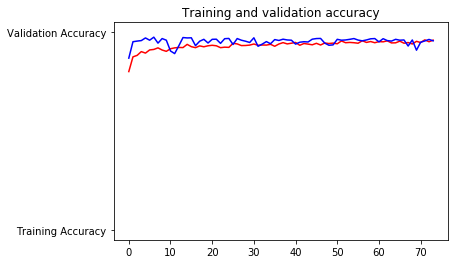

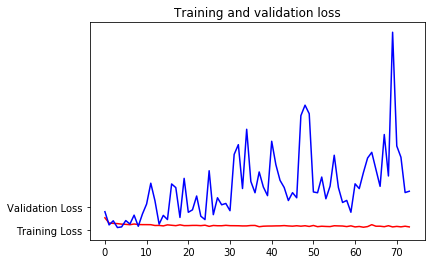

In [49]:
# fetch model (training)

print("\nTraining model...")
model = fetch_model(train_gen, val_gen)
print("\nTraining Complete")



## predict on test images from kaggle

#### unzip test data


In [0]:
#### unzip test data
test_dir = '/tmp/test'
test_zip_dir = '/content/test1.zip'
zipref = zipfile.ZipFile(test_zip_dir, 'r')
zipref.extractall(test_dir)
zipref.close()

#### load test data through generator

In [57]:
test_data_gen = ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_directory(
                    test_dir,
                    target_size=((Nrows, Ncols)),
                    class_mode='binary')

Found 12500 images belonging to 1 classes.


In [0]:
result = model.predict_generator(test_gen)

In [59]:
print(result[1:10])

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


#### create test_list


In [64]:
#### create test_list

test_list = glob.glob(test_dir+'/test1/*.jpg')
print(len(test_list))


12500


Save the submission file

In [70]:
# save the submission file
import numpy as np

idx = []
for i in test_list:
    idx.append(i[18:-4])
print(len(test_list))
print(len(idx))
print(result.shape)
result = result.reshape(result.shape[0])
submission = {"id": idx, "label": result}
pd.DataFrame(submission).to_csv("/content/submission.csv", index=False)



12500
12500
(12500, 1)


In [0]:
# predict for new uploaded images

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(Nrows, Ncols))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

MessageError: ignored